# Exploring the Performance of K-Nearest Neighbors (KNN) on the Fisher Iris Dataset
In this notebook, we will
1.   Run the KNN algorithm on the Fisher Iris dataset using the scikit-learn library.
2.   Visualize how much each label contributes to the total number of misclassifications, for each k value.
3.   Visualize the 2D projection of the dataset using Principle Analysis Component (PCA).

## Part 1: KNN algorithm on the Fisher Iris dataset

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

After loading the necessary packages, we will run the KNN algorithm from scikit-learn on the dataset where each step in the code is in-line-documented. Some steps worth talking about, though, are:


1.   `StandardScaler` will standardize features by removing the mean and scaling to unit variance.
2.   `StratifiedShuffleSplit` will provide train/test indices to split data in train/test sets while preserving the percentage of samples for each class.



In [ ]:
# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize variables
k_values = range(1, 21)
mean_accuracies = []

# Create a StratifiedShuffleSplit object, with K=50 folds, and 1/3 split for testing
splitter = StratifiedShuffleSplit(n_splits=50, test_size=1/3, random_state=42)

# Store how much each label contributes to the misclassifications, for each k
misclassification_percentages = []

# Loop through each k value from 1 to 20
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    fold_accuracies = []

    # Initialize variables to store total misclassifications for each label
    total_misclassifications_per_label = {label: 0 for label in np.unique(y)}
    total_misclassifications = 0

    # Loop through each fold from 1 to 50
    for train_index, test_index in splitter.split(X_scaled, y):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit the model and predict
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        # Calculate accuracy
        fold_accuracy = accuracy_score(y_test, y_pred)
        fold_accuracies.append(fold_accuracy)

        # Identify misclassified samples
        misclassified_mask = y_test != y_pred  # Boolean mask of misclassified samples
        misclassified_labels = y_test[misclassified_mask]  # True labels of misclassified samples

        # Update counts for each misclassified label
        for label in misclassified_labels:
            total_misclassifications_per_label[label] += 1
        total_misclassifications += len(misclassified_labels)

    # Calculate percentage contribution of each label to total misclassifications
    if total_misclassifications > 0:
        misclassification_percentage_for_k = {
            label: (count / total_misclassifications) * 100
            for label, count in total_misclassifications_per_label.items()
        }
    else:
        misclassification_percentage_for_k = {label: 0 for label in np.unique(y)}

    # Store the percentage contribution for this k
    misclassification_percentages.append((k, misclassification_percentage_for_k))

    # Average accuracy over the 50 folds
    mean_accuracy = np.mean(fold_accuracies)
    mean_accuracies.append(mean_accuracy)

Once we store the average accuracy for each k value, we can plot a line graph to see the relationship between them like below.

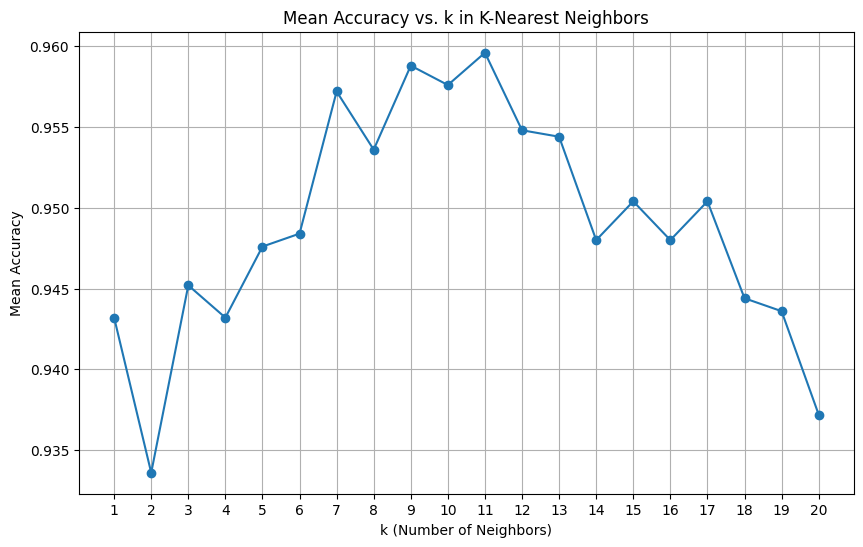

In [ ]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_accuracies, marker='o')
plt.title('Mean Accuracy vs. k in K-Nearest Neighbors')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Mean Accuracy')
plt.grid(True)
plt.xticks(k_values)
plt.show()

## Part 2: Visualize percentage contribution of each label to total misclassifications, for each k value

Here, we have the most important input to this visualization, which is `misclassification_percentages` that was calculated above. We can use matplotlib to create a stacked bar chart out of it. Each step in the code below is in-line-documented again.

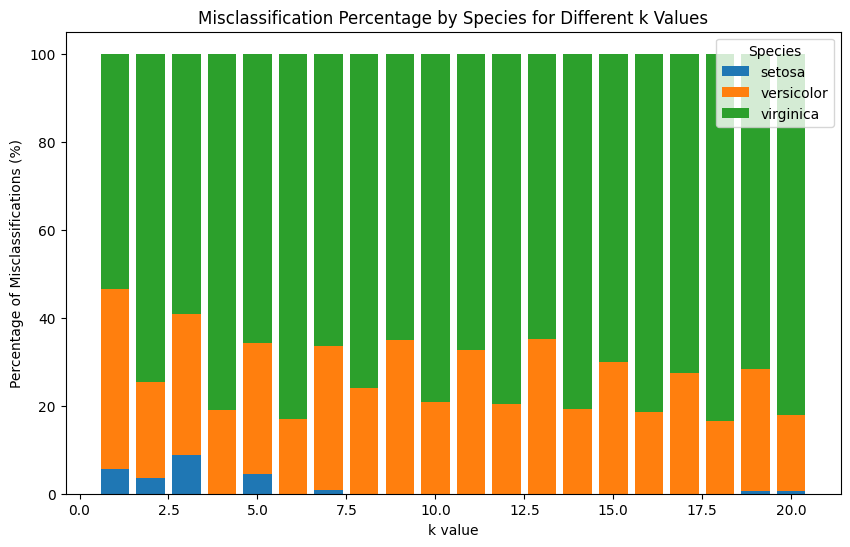

In [ ]:
# Extract label names from the dataset
label_names = iris.target_names  # This gives array(['setosa', 'versicolor', 'virginica'])

# Unique labels in the dataset (0, 1, 2)
labels = np.unique(y)

# Extracting data for visualization
k_values = range(1, 21)

# Initialize an array to store the misclassification percentages for each label
percentages_per_label = {label: [] for label in labels}

# Populate percentages for each label from misclassification_percentages
for k, percentages in misclassification_percentages:
    for label in labels:
        percentages_per_label[label].append(percentages[label])

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for each label as a stacked bar
bottom = np.zeros(len(k_values))  # Initialize the bottom for stacking
for label in labels:
    ax.bar(k_values, percentages_per_label[label], bottom=bottom, label=label_names[label])
    bottom += percentages_per_label[label]  # Update bottom for the next label's bar

# Add labels and title
ax.set_xlabel('k value')
ax.set_ylabel('Percentage of Misclassifications (%)')
ax.set_title('Misclassification Percentage by Species for Different k Values')
ax.legend(title='Species')

# Show plot
plt.show()

## Part 3: 2D data projection using PCA

In [ ]:
# Importing the necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

After loading the necessary packages, we will run a 2D projection using PCA from scikit-learn on the training dataset, and then visualize this transformed data. Again, each step in the code is in-line-documented.


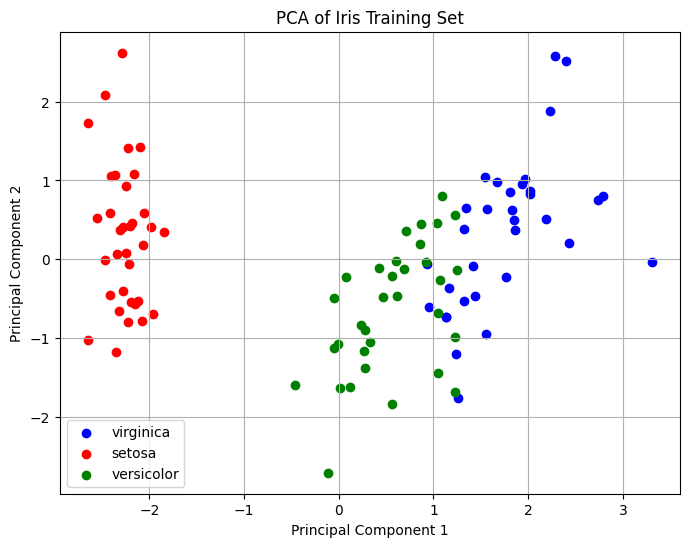

In [ ]:
# Split the data into 2/3 training and 1/3 testing while preserving the class distribution
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=1/3, random_state=42, stratify=y)

# Perform 2D projection on the training set using PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Prepare the result as a DataFrame for better readability and visualization
train_pca_df = pd.DataFrame(X_train_pca, columns=["PC1", "PC2"])
train_pca_df['label'] = y_train

# Plot the 2D PCA projection
plt.figure(figsize=(8, 6))
colors = ['r', 'g', 'b']
for label in train_pca_df['label'].unique():
    subset = train_pca_df[train_pca_df['label'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=iris.target_names[label], c=colors[label])

plt.title('PCA of Iris Training Set')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()